<a href="https://colab.research.google.com/github/Lethe-diana/ALTINO_Ah-Choo/blob/master/Brain_Tumor_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d preetviradiya/brian-tumor-dataset

brian-tumor-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!mkdir data
!unzip brian-tumor-dataset.zip -d data

mkdir: cannot create directory ‘data’: File exists
Archive:  brian-tumor-dataset.zip
replace data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Brain Tumor Dataset

In [5]:
import torch
from torch.utils import data
import torchvision
import torchvision.transforms as transforms

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
METADATA_ROOT = 'data/metadata.csv'
METADATA_RGB_ROOT = 'data/metadata_rgb_only.csv'
IMAGES_FOLDER = 'data/Brain Tumor Data Set/Brain Tumor Data Set'

In [7]:
NORMAL_ROOT = os.path.join(IMAGES_FOLDER, 'Healthy')
TUMOR_ROOT = os.path.join(IMAGES_FOLDER, 'Brain Tumor')

In [8]:
labels_map = {'normal': 0, 'tumor': 1}

### investigate size of images

In [ ]:
metadata = pd.read_csv(METADATA_ROOT, index_col=0)
metadata.head()

,image,class,format,mode,shape
0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


In [ ]:
# turn string data into ndarray
metadata['shape'] = metadata['shape'].apply(
    lambda x: np.fromstring(x[1:-1], dtype=int, sep=',')
)
# padding 2darray to 3darray
metadata['shape'] = metadata['shape'].apply(
    lambda x: np.pad(x, (0, 1), 'constant', constant_values=1) if x.shape[0]==2 else x
)

In [ ]:
metadata['shape']

0       [512, 512, 3]
1       [300, 240, 1]
2       [256, 256, 3]
3       [512, 512, 3]
4       [256, 256, 3]
            ...      
4595    [168, 300, 3]
4596    [509, 452, 3]
4597    [197, 177, 3]
4598    [217, 232, 3]
4599    [221, 228, 3]
Name: shape, Length: 4600, dtype: object

In [ ]:
shapes = metadata['shape'].to_numpy()
shapes = np.stack(shapes)

In [ ]:
np.mean(shapes, axis=0)

array([378.66934783, 359.48847826,   2.94282609])

In [ ]:
np.mean(np.mean(shapes, axis=0)[:2])

369.0789130434782

###label

In [ ]:
df = pd.read_csv(METADATA_ROOT, usecols=['image', 'class'],
            converters={'class': lambda x: labels_map.get(x)})
df

,image,class
0,Cancer (1).jpg,1
1,Cancer (1).png,1
2,Cancer (1).tif,1
3,Cancer (10).jpg,1
4,Cancer (10).tif,1
...,...,...
4595,Not Cancer (995).jpg,0
4596,Not Cancer (996).jpg,0
4597,Not Cancer (997).jpg,0
4598,Not Cancer (998).jpg,0


In [ ]:
df.iloc[0, 0], df.iloc[0, 1]

('Cancer (1).jpg', 1)

### Preprocessing

In [100]:
img = Image.open('/content/data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg')

In [96]:
img = transforms.ToTensor()(img)
img.shape

torch.Size([3, 512, 512])

In [53]:
img = torchvision.io.read_image(
    '/content/data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg')
img2 = torchvision.io.read_image(
    '/content/data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).png')

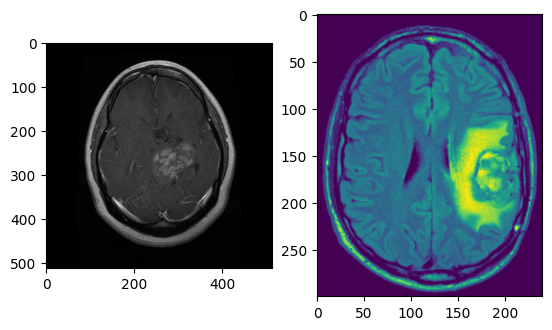

In [ ]:
plt.figure(1)
plt.subplot(121)
plt.imshow(img.permute(1,2,0))
plt.subplot(122)
plt.imshow(img2.permute(1,2,0))
plt.show()

In [ ]:
print(img.size(), img2.size())

torch.Size([3, 512, 512]) torch.Size([1, 300, 240])


In [ ]:
gray_img = transforms.Grayscale()(img)
gray_img2 = transforms.Grayscale()(img2)

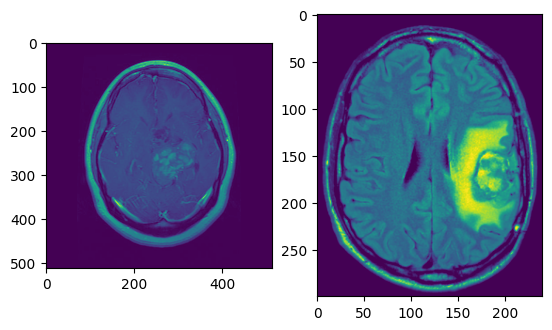

In [ ]:
plt.figure(1)
plt.subplot(121)
plt.imshow(gray_img.permute(1,2,0))
plt.subplot(122)
plt.imshow(gray_img2.permute(1,2,0))
plt.show()

In [ ]:
print(gray_img.size(), gray_img2.size())

torch.Size([1, 512, 512]) torch.Size([1, 300, 240])


In [ ]:
resized_gray_img = transforms.Resize((369, 369))(gray_img)
resized_gray_img2 = transforms.Resize((369, 369))(gray_img2)

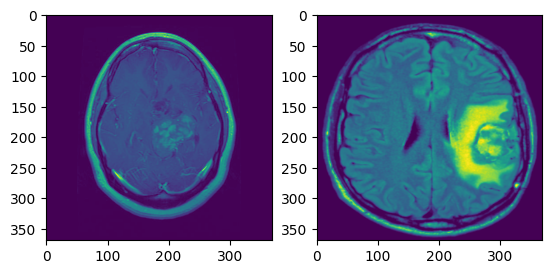

In [ ]:
plt.figure(1)
plt.subplot(121)
plt.imshow(resized_gray_img.permute(1,2,0))
plt.subplot(122)
plt.imshow(resized_gray_img2.permute(1,2,0))
plt.show()

In [ ]:
print(resized_gray_img.size(), resized_gray_img2.size())

torch.Size([1, 369, 369]) torch.Size([1, 369, 369])


## Transform and Dataset

In [18]:
remove_alpha_ch = transforms.Lambda(lambda x: x[:3])

transform = transforms.Compose([
    transforms.ToTensor(),
    remove_alpha_ch,
    transforms.Grayscale(),
    transforms.Resize((369, 369)),
    transforms.Normalize((0.5), (0.5))
])

In [19]:
class BrainTumorDataset(data.Dataset):
  def __init__(self, annotation_file, normal_dir, tumor_dir, transform=None):
    self.img_labels = pd.read_csv(annotation_file, usecols=['image', 'class'],
                                  converters={'class': lambda x: labels_map.get(x)})
    self.normal_dir = normal_dir
    self.tumor_dir = tumor_dir
    self.transform = transform

  def __getitem__(self, idx):
    # label
    label = self.img_labels.iloc[idx, 1]
    # label = torch.tensor(label)

    # img
    img_dir = self.normal_dir if label== 0 else self.tumor_dir
    img_path = os.path.join(img_dir, self.img_labels.iloc[idx, 0])
    # image = torchvision.io.read_image(img_path)
    image = Image.open(img_path)

    # transform
    if self.transform:
      image = self.transform(image)

    return image, label

  def __len__(self):
    return len(self.img_labels)

In [20]:
dataset = BrainTumorDataset(METADATA_ROOT, NORMAL_ROOT, TUMOR_ROOT, transform)

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = data.random_split(
    dataset, [0.8, 0.1, 0.1], generator=generator
)

In [21]:
train_dataloader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = data.DataLoader(val_dataset, batch_size=64, shuffle=True)

# Define ConvNet

In [37]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 3)
    self.pool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.conv3 = nn.Conv2d(64, 128, 3)
    self.pool3 = nn.MaxPool2d(2, 2)
    self.fc = nn.Sequential(
        nn.Linear(247808, 1000),
        nn.BatchNorm1d(1000),
        nn.ReLU(),
        nn.Linear(1000, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.Linear(100, 2),
    )

  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = self.pool3(F.relu(self.conv3(x)))
    x = torch.flatten(x, 1)
    y_hat = self.fc(x)
    return y_hat

convnet = ConvNet()

print(convnet)

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Sequential(
    (0): Linear(in_features=247808, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=2, bias=True)
  )
)


# Train Model

In [38]:
import torch.optim as optim

# set loss function
loss_fn = nn.CrossEntropyLoss()
# set optimizer
optimizer = optim.Adam(convnet.parameters(), lr=0.001, betas=(0.9, 0.999))

In [25]:
from tqdm import tqdm, trange

def train_loop(dataloader, model, loss_fn, optimizer, device):
  for X, y in tqdm(dataloader):
    X = X.to(device)
    y = y.to(device)

    # prediction and loss
    pred = model(X)
    loss = loss_fn(pred, y)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def test_loop(dataloader, model, loss_fn, device):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  loss, accuracy = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      pred = model(X)
      loss += loss_fn(pred, y).item()
      accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

  loss /= num_batches
  accuracy /= size
  return loss, accuracy

In [39]:
def train_model(train_dataloader, val_dataloader,
                model, loss_fn, optimizer, num_epochs=10):
  # device
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  min_val_loss = np.inf

  # train model
  for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}\n-----------------')
    # train
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
    # validate
    val_loss, val_acc = test_loop(val_dataloader, model, loss_fn, device)
    print(f'val_loss: {val_loss:.4f}, val_acc: {(val_acc*100):.4f}%')
    # save model with least val_loss
    if val_loss < min_val_loss:
      min_val_loss = val_loss
      torch.save(model, f'{model.__class__.__name__}.pth')

In [40]:
train_model(train_dataloader, val_dataloader,
            convnet, loss_fn, optimizer)

Epoch 1/10
-----------------


  0%|          | 0/58 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 58/58 [00:18<00:00,  3.08it/s]


val_loss: 0.3206, val_acc: 85.6522%
Epoch 2/10
-----------------


100%|██████████| 58/58 [00:18<00:00,  3.11it/s]


val_loss: 0.2093, val_acc: 92.6087%
Epoch 3/10
-----------------


100%|██████████| 58/58 [00:18<00:00,  3.11it/s]


val_loss: 0.1407, val_acc: 95.8696%
Epoch 4/10
-----------------


100%|██████████| 58/58 [00:18<00:00,  3.08it/s]


val_loss: 0.1857, val_acc: 96.5217%
Epoch 5/10
-----------------


100%|██████████| 58/58 [00:18<00:00,  3.15it/s]


val_loss: 0.2044, val_acc: 95.8696%
Epoch 6/10
-----------------


100%|██████████| 58/58 [00:18<00:00,  3.15it/s]


val_loss: 0.1832, val_acc: 96.0870%
Epoch 7/10
-----------------


100%|██████████| 58/58 [00:18<00:00,  3.18it/s]


val_loss: 0.1635, val_acc: 95.6522%
Epoch 8/10
-----------------


100%|██████████| 58/58 [00:18<00:00,  3.09it/s]


val_loss: 0.1662, val_acc: 96.0870%
Epoch 9/10
-----------------


100%|██████████| 58/58 [00:18<00:00,  3.12it/s]


val_loss: 0.1817, val_acc: 95.6522%
Epoch 10/10
-----------------


100%|██████████| 58/58 [00:18<00:00,  3.20it/s]


val_loss: 0.1702, val_acc: 95.6522%


# GPU 캐시 비워주기 (CUDA out of memory)

In [36]:
import gc
gc.collect()
torch.cuda.empty_cache()

# Test Model

In [47]:
# load model with least val_loss
convnet = torch.load('ConvNet.pth')
# device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# test model
test_loss, test_acc = test_loop(test_dataloader, convnet, loss_fn, device)
print(f'test_acc: {(test_acc*100):.4f}%')

test_acc: 96.3043%
